In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Q1 find top 30 and save into seperate csvs

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
data_path = '/content/drive/MyDrive/Course/Python/'
sys.path.append(os.path.abspath(data_path))
df = pd.read_feather(data_path + 'RC_2012_year_cohort.feather')

subreddit_counts = df.groupby('subreddit')['created_utc'].count()
top_subreddits = subreddit_counts.sort_values(ascending=False)[:30]

sub_names = []
for subreddit, count in top_subreddits.items():
  sub_names.append(subreddit)
  print(f"{subreddit}: {count}")

In [ ]:
for subreddit, count in top_subreddits.items():
    subsec = df[df['subreddit'] == subreddit]
    subsec.to_csv(data_path + f'{subreddit}.csv', index=False)
    del subsec
del df

# following steps experiment

In [ ]:
sub_names = ['AskReddit','funny','pics','gaming','WTF',
             'politics','atheism','leagueoflegends','IAmA','trees',
             'videos','AdviceAnimals','todayilearned','fffffffuuuuuuuuuuuu','worldnews',
             'gonewild','nfl','movies','starcraft','aww',
             'technology','Minecraft','soccer','Music','nba',
             'Diablo','mylittlepony','Guildwars2','Games','guns']

In [3]:
import sys
import os
import numpy as np
import pandas as pd
data_path = '/content/drive/MyDrive/Course/Python/top30_csv/'
sys.path.append(os.path.abspath(data_path))

In [ ]:
#def open_file(filename):
    #df = pd.read_csv(data_path + filename + ".csv")
    #df_name = filename + '_df'
    #globals()[df_name] = df

In [4]:
def open_file(filename):
    df = pd.read_csv(data_path + filename + ".csv")
    return df

# Steps 1-4

1. get first interaction date
2. calculate relative time (comment day - first interaction date)
3. drop duplicate rows

In [5]:
def interaction(subreddit):
    """
    input: str, subreddit name
    output: df, dataframe with 2 columns [author, days_since_first_interaction]
    """
    
    df = open_file(subreddit)

    subreddit_df = df[df['subreddit'] == subreddit][['author', 'created_utc']]
    
    # timestamp -> datetime
    subreddit_df['created_date'] = pd.to_datetime(subreddit_df['created_utc'], unit='s').dt.date
    
    # first intercation date for each author
    first_interactions = subreddit_df.groupby('author')['created_utc'].min()
    first_interactions = pd.to_datetime(first_interactions, unit='s').dt.date
    
    # Merge the two dataframes on the author column
    merged_df = pd.merge(
        subreddit_df,
        pd.DataFrame({'author': first_interactions.index, 'first_interaction_date': first_interactions.values}),
        on='author'
    )

    # the number of days since each author's first comment
    merged_df['days_since_first_interaction'] = (merged_df['created_date'] - merged_df['first_interaction_date']).dt.days
    
    
    final_df = merged_df.drop(['created_utc', 'created_date', 'first_interaction_date'], axis=1)
    # Remove duplicates (only consider one comment per author per day)
    final_df.drop_duplicates(['author', 'days_since_first_interaction'], inplace=True)
    
    return final_df

In [ ]:
for i in sub_names:
  final_df = interaction(i)
  ...

In [8]:
final_df = interaction('guns')
final_df

,author,days_since_first_interaction
0,Pomberella2,0
2,CountNefarious,0
3,CountNefarious,106
4,CountNefarious,107
5,CountNefarious,125
...,...,...
1024152,phulton,0
1024154,mcaok,0
1024156,TheDuckontheJuneBug,0
1024158,datkidbrad,0


In [7]:
final_df = interaction('Games')
final_df

,author,days_since_first_interaction
0,MrBlueberryMuffin,0
9,MrBlueberryMuffin,47
11,MrBlueberryMuffin,69
12,MrBlueberryMuffin,71
13,MrBlueberryMuffin,78
...,...,...
1068522,oneIozz,0
1068523,MrAustizy,0
1068524,zdenko1,0
1068525,LeeHarveyShazbot,0


# Step 5-8
1. Pivot the dataframe so the names of authors are on one axis and the days on which they commented are on the second axis. This should be a pretty sparse matrix. Most authors will not comment on most days. Therefore, entries in those cells will be 0. The remaining cells will contain 1, to indicate that they did indeed comment on that day (remember that we don't care about multiple comments, so the cells should either contains a zero or a one).


In [ ]:
def make_pivot(dff):
  """
  input: dataframe
  output: a series
  """
  # pivot the data
  sparse_matrix = dff.pivot(index='author', columns='days_since_first_interaction',values='days_since_first_interaction')
  sparse_matrix[sparse_matrix.notnull()] = 1
  sparse_matrix = sparse_matrix.fillna(0)

  num_commenters_per_day = sparse_matrix.sum(axis=0)

  num_authors_day_0 = sparse_matrix.loc[:, 0].sum()
  # get the number of authors who commented on each subsequent day
  num_authors_per_day = num_commenters_per_day[1:]
  # calculate the percentage of authors who returned after their first comment
  percent_returning_authors = num_authors_per_day / num_authors_day_0 * 100

  return percent_returning_authors

In [ ]:
def combined_process(sub_name):
  """
  input: str, subreddit name
  output: a series
  """
  final_df = get_author_activity(sub_name)
  percent_return = make_pivot(final_df)
  output_name = sub_name + "_percent_return"
  globals()[output_name] = percent_return
  #return percent_return.rename(output_name)

def combined_process(sub_name):

  """

  input: str, subreddit name

  output: a series

  """

  final_df = get_author_activity(sub_name)

  percent_return = make_pivot(final_df)

  output_name = sub_name + "_percent_return"

  return percent_return.rename(output_name)
  

In [ ]:
sub_names[-5:]

['Diablo', 'mylittlepony', 'Guildwars2', 'Games', 'guns']

In [ ]:
sub_list = sub_names[-10:]
for i in sub_list:
#for i in sub_name:
  combined_process(i)

In [ ]:
guns_percent_return

days_since_first_interaction
1      14.871870
2       8.188607
3       6.715478
4       6.097525
5       5.693367
         ...    
330     0.606238
331     0.550593
332     0.492019
333     0.371943
334     0.228438
Length: 334, dtype: float64

# Plot

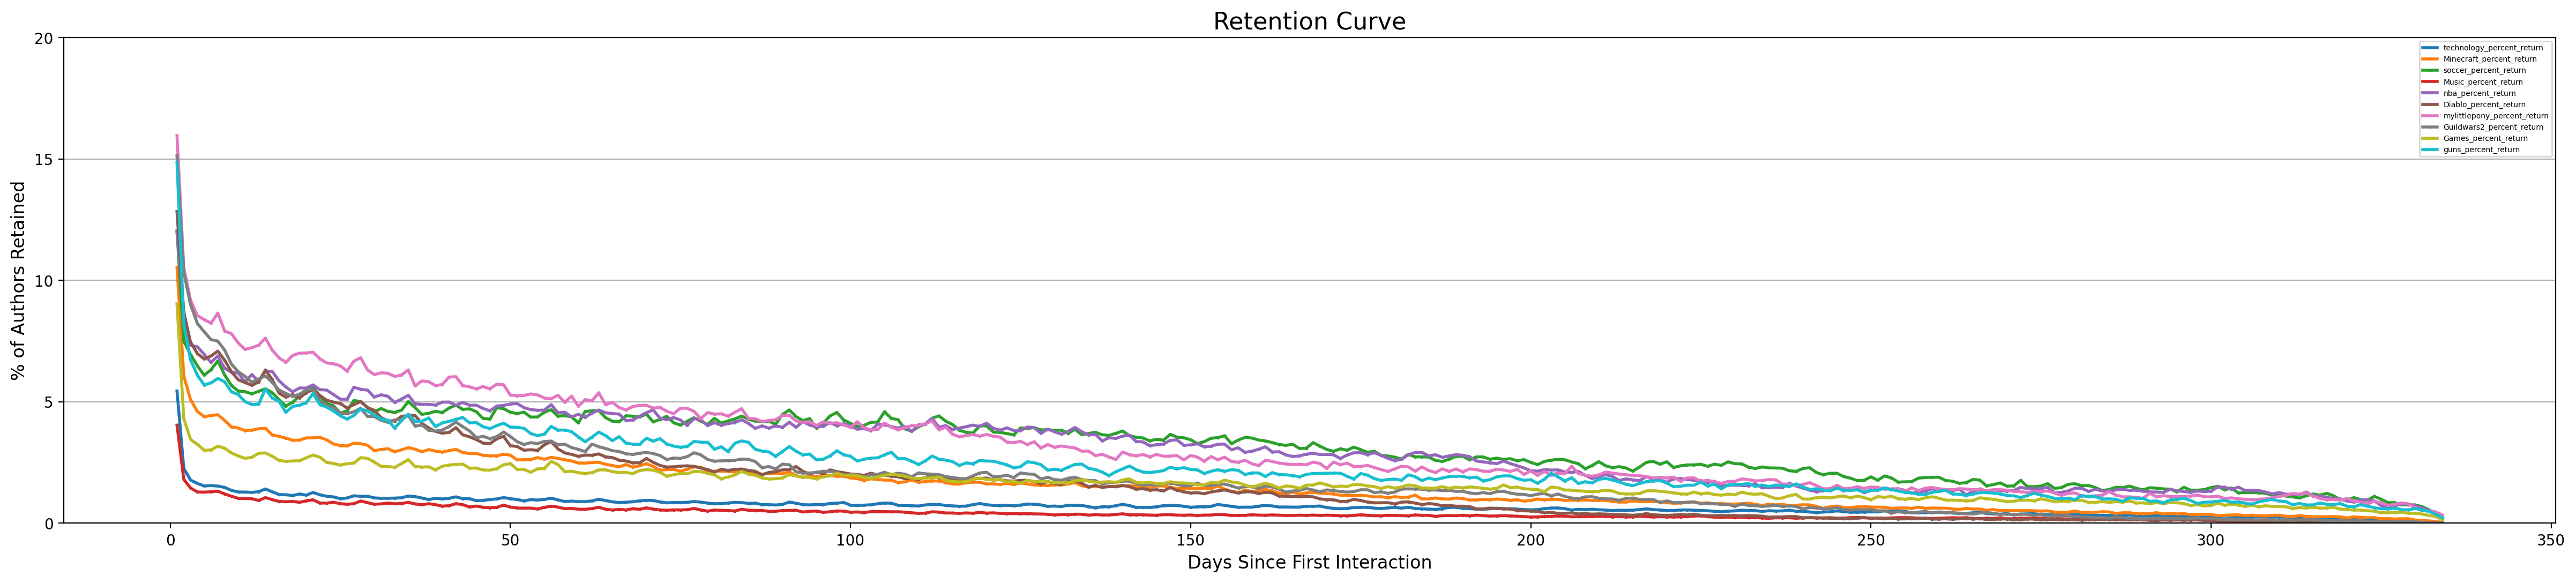

In [ ]:
import matplotlib.pyplot as plt

# plot the retention curve
plt.figure(figsize=(30, 6),dpi=200)

series_list=[]
for i in sub_list:
  series1 = i + "_percent_return"
  series_list.append(series1)

for var_name in series_list:
    var_obj = globals()[var_name]
    plt.plot(var_obj.index, var_obj.values, marker='o', markersize=1, linewidth=2,label=var_name)

# set the title and labels
plt.title('Retention Curve', fontsize=16)
plt.xlabel('Days Since First Interaction', fontsize=12)
plt.ylabel('% of Authors Retained', fontsize=12)

# set the y-axis limits and ticks
plt.ylim(0, 20)
plt.yticks(np.arange(0, 21, 5))

# display the grid
plt.grid(True, axis='y', alpha=5)
plt.legend(fontsize=5)

# display the plot
plt.show()